# **XRAI: Практика**

Привет, друзья! Как и в прежних модулях — будем закреплять теорию на практике. На очереди у нас XRAI — метод, позволяющий получить не отдельные пиксели, а пиксели, объединенные в регионы.

Переход от пикселей к регионам дает нам дает детали более высокого уровня абстракции (можно заключать вывод не о влиянии конкретных пикселей, а о влиянии конкретных частей или объектов изображения). В некоторых случаях это делает XRAI отличным продолжением градиентного метода, на котором он основан (вспомните, какого!).

В этой практике вы
- Получите навыки в работе в библиотекой `saliency` — единнственной (на период написания курса) framework-agnostic библиотекой объеснения.
- Реализуете и проанализируете результаты метода XRAI
- Сравните информативность карты, полученной XRAI, с картой метода, предлагающего атрибуции без сегментов.

**Как всегда — приятного кодинга!**

<a href="https://ibb.co/N1Tq1bx"><img src="https://i.ibb.co/RhjKhd2/glen-carrie-4-Qr-Cip9gbx-Q-unsplash.jpg" alt="glen-carrie-4-Qr-Cip9gbx-Q-unsplash" border="0"></a>


In [ ]:
!pip3 uninstall numpy -y

In [1]:
!pip3 install saliency torch torchvision captum numpy==1.26.4 -q # если нужно — перезапустите ноутбук, чтобы встала корректная версия numpy

**Пока устанавливаются необходимые библиотеки ответьте, на каком градиентном методе основан XRAI?**

In [2]:
# Необходимые импорты

import numpy as np
print(np.__version__)
import PIL.Image
from matplotlib import pylab as P
import matplotlib.pyplot as plt
import torch
import urllib
from torchvision import models, transforms

import saliency.core as saliency

from datetime import datetime

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

%matplotlib inline

from PIL import Image
from io import BytesIO
import requests

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "imagenet_classes.txt")

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

Как и в прошлых шагах сначала загрузим изображение. Для интереса, изображение будем использовать сложное — на нем будет находится кошка, сидящая в шкафу с посудой.

In [3]:
cat_url = 'https://github.com/SadSabrina/explainable_AI_course/blob/a719daa485b85b94d4a60fff7f5e33ae39880461/HW_module12_concept%20based/cat_plates_cupboard.jpg?raw=true'


image_bytes = requests.get(cat_url).content
image = Image.open(BytesIO(image_bytes)) # загрузим нашу кошку

Подготовим pipeline предобработки.

In [4]:
# предобработка изображения, которое будем подавать на вход модели
to_tensor_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
])



# простой ресайз на оригинальным изображением, чтобы сохранить его в привычном для нас виде
original_image = image.resize((256, 256))

In [5]:
input_image = to_tensor_transform(original_image)

Визуально зафиксируем вид оригинала и преобразованного изображения.

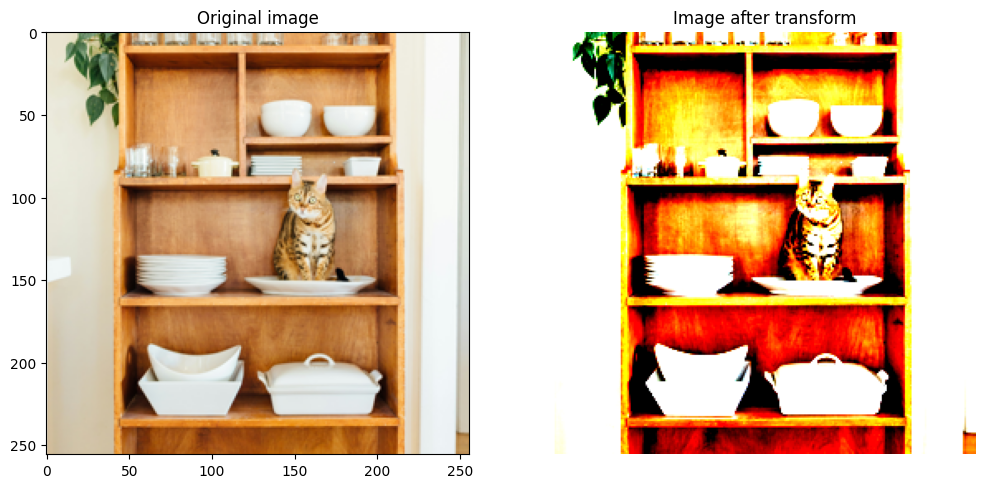

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(original_image)
ax[0].set_title('Original image')

ax[1].imshow(input_image.permute((1, 2, 0)))
ax[1].set_title('Image after transform')
plt.axis('off');

Теперь, как всегда зафиксируем возвращение градиентов и добавим размерность батча для подачи картинки модели. Сделайте это самостоятельно.

In [ ]:
# Ваш код здесь

**Чему равна сумма размерностей входной картинки (`input image`) после добавления 4й размерности?**

Теперь загрузим модель. Возьмем уже знакомого нам `swin`'а.

In [8]:
model = models.swin_t(weights='IMAGENET1K_V1')
model.eval();

### **Функции для XRAI**

Логика библиотеки `saliency`, требует для запуска алгоритма XRAI строго определенного вида сущности — `call_model_function`. Как должна выглядеть функция есть в официальном туториале библиотеки и изложено в ячейке ниже. Разберёмся, почему она должна выглядеть именно так.

In [9]:
def call_model_function(images, call_model_args=None, expected_keys=None):

   ### Предобработка батча изображений — начало

    transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

    prep_images = np.transpose(images, (0,3,1,2))
    prep_images = torch.tensor(prep_images, dtype=torch.float32)
    prep_images = transformer.forward(prep_images)
    prep_images.requires_grad_(True)

    ### Предобработка батча изображений — конец

    target_class_idx = call_model_args[class_idx_str]
    output = model(prep_images) # получаем выход модели
    m = torch.nn.Softmax(dim=1) # пропускаем все значения через softmax
    output = m(output)

    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, prep_images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

- `images`:
   - должны быть заданы строго в виде numpy array, так как при извлечении масок проверяется размерность изображения, что требует у него наличия атрибута `shape`;
   - должны содержать оригинальное изображение;

- Наличие логического условия (if-else):
  - позволяет использовать данную функцию универсально для любого метода атрибуции в библиотеке `saliency`. Конкретно, используя метод XRAI вы попадаете под условие if.

**Вопрос: что возвращает `call_model_function` для метода XRAI?**



Теперь получим прогноз модели и проверифицируем топ-5 прогнозов. Сделайте это самостоятельно.

In [ ]:
predictions = # Ваш код здесь

softmax = torch.nn.Softmax(dim=1) # пропустим также все значения через softmax
predictions_probas = softmax(predictions)

# Извлечем топ5 и топ1

top5 = # Ваш код здесь

predictions_probas = # Ваш код здесь
prediction_class = np.argmax(predictions_probas[0])

print("Prediction class: " + str(prediction_class))

In [ ]:
top5_indexes = top5.indices.detach().numpy()[0]
top5_values = # Ваш код здесь

for idx, value in zip(top5_indexes, top5_values):
  print(f'Categorie: "{categories[idx]}" with idx {idx}, value={round(value, ndigits=2)}')

**Чему равна вероятность класса под номером 4, округленная до десятых?**



Можно заметить, что внимание модели "заострено" на топ-3. Теперь настало время посмотреть, на какие детали модель обращает внимание, делая такой выбор, при помощи XRAI!

In [12]:
# Внимание модели при прогнозе класса 495

class_idx_str = 'class_idx_str'
class_interested = 495 # Выберем спрогнозированный класс как класс для объяснения и занесем его в call_model_args


call_model_args = {class_idx_str: prediction_class}

start_time = datetime.now()
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()


# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(np.array(original_image), call_model_function, call_model_args, batch_size=1)

print('Computation time:', datetime.now() - start_time)

Computation time: 0:03:37.634792


Визуализируем результат атрибуции признаков при помощи XRAI.

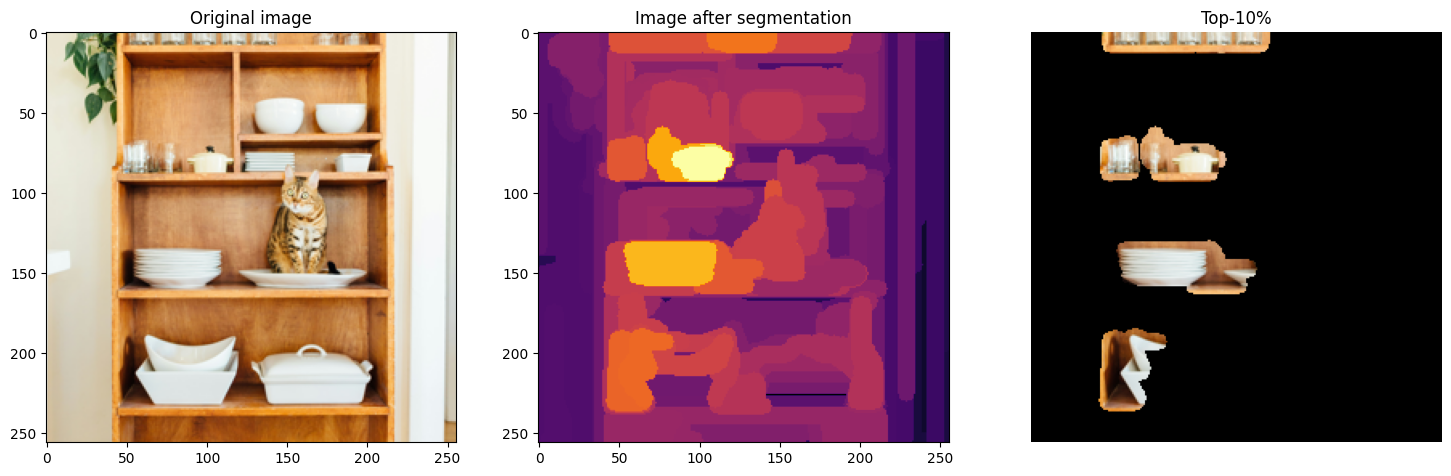

In [13]:
# Show most salient 10% of the image
mask = xrai_attributions >= np.percentile(xrai_attributions, 90)
im_mask = np.array(original_image)
im_mask[~mask] = 0

fig, ax = plt.subplots(1, 3, figsize=(18, 8))

ax[0].imshow(original_image)
ax[0].set_title('Original image')

ax[1].imshow(xrai_attributions, cmap='inferno')
ax[1].set_title('Image after segmentation')

ax[2].imshow(im_mask)
ax[2].set_title('Top-10%')
plt.axis('off');

Модель "обращает внимание" на посуду и прогнозирует весьма закономерный класс — шкаф для посуды (china cabinet). Посмотрим, как "внимание" модели выглядит через призму Integrated Gradients.

In [14]:
integrated_gradients = IntegratedGradients(model)
model.zero_grad()
captum_ig_attributions = integrated_gradients.attribute(inputs=input_image,
                                                        baselines=input_image * 0,
                                                        target=495,
                                                        n_steps=50,
                                                        method='riemann_right')


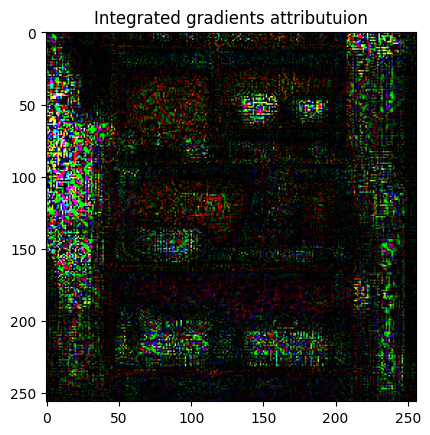

In [15]:
plt.imshow(captum_ig_attributions.squeeze(0).permute((1, 2, 0)).detach().numpy()*10)
plt.title('Integrated gradients attributuion');

Как видим, результат аналогичен, однако детализация при помощи Integrated Gradients позволяет также увидеть, что модель "заостряет внимание" на границах шкафа (возможно, на наличии стены), чего не показывает сегментация.

**Постройте карты для целевого класса (285, Egyptian cat) обоими методами и проанализируйте результат. Какой метод атрибуции вам кажется подходит здесь лучше?**

**Сформулируйте выводы и напишите их в виде небольшого текста (эссе).**

In [16]:
# Внимание модели при прогнозе класса 285

class_idx_str = 'class_idx_str'
class_interested = 285 # Выберем спрогнозированный класс как класс для объяснения и занесем его в call_model_args


call_model_args = {class_idx_str: prediction_class}

start_time = datetime.now()
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()


# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(np.array(original_image), call_model_function, call_model_args, batch_size=1)

print('Computation time:', datetime.now() - start_time)

Computation time: 0:03:38.743065


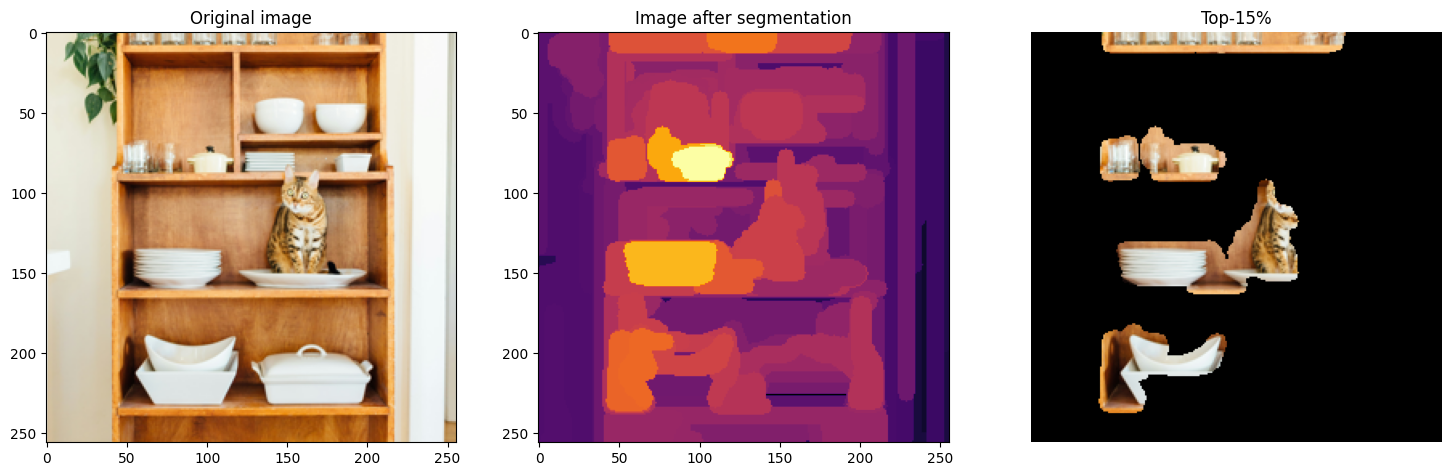

In [23]:
# Топ 10 самых важных зон для модели
mask = xrai_attributions >= np.percentile(xrai_attributions, 85)
im_mask = np.array(original_image)
im_mask[~mask] = 0

fig, ax = plt.subplots(1, 3, figsize=(18, 8))

ax[0].imshow(original_image)
ax[0].set_title('Original image')

ax[1].imshow(xrai_attributions, cmap='inferno')
ax[1].set_title('Image after segmentation')

ax[2].imshow(im_mask)
ax[2].set_title('Top-15%')
plt.axis('off');

In [18]:
integrated_gradients = IntegratedGradients(model)
model.zero_grad()
captum_ig_attributions = integrated_gradients.attribute(inputs=input_image,
                                                        baselines=input_image * 0,
                                                        target=285,
                                                        n_steps=50,
                                                        method='riemann_right')


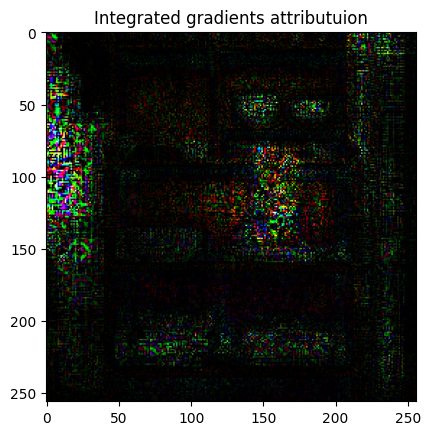

In [19]:
plt.imshow(captum_ig_attributions.squeeze(0).permute((1, 2, 0)).detach().numpy()*10)
plt.title('Integrated gradients attributuion');

В качестве последнего момента, на котором хочется заострить внимание покажем, что есть способ строить XRAI карты более быстро.

1. Первое — реализовать кастомную сегментацию или использовать уже размеченные изображение
2. Второе — использовать быстрый вариант алгоритма, но здесь важно держать в голове, что он дает приближенный результат, которые может отличаться от XRAI без ускорения и не на всех изображениях позволяет выиграть много времени.

In [20]:
# Внимание модели при прогнозе класса 285

class_idx_str = 'class_idx_str'
class_interested = 285 # Выберем спрогнозированный класс как класс для объяснения и занесем его в call_model_args


call_model_args = {class_idx_str: prediction_class}

start_time = datetime.now()

# Create XRAIParameters and set the algorithm to fast mode which will produce an approximate result.
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

xrai_params = saliency.XRAIParameters()
xrai_params.algorithm = 'fast'

# Compute XRAI attributions with fast algorithm
xrai_attributions_fast = xrai_object.GetMask(np.array(original_image), call_model_function, call_model_args, extra_parameters=xrai_params, batch_size=1)

print('Computation time:', datetime.now() - start_time)

Computation time: 0:03:23.242210


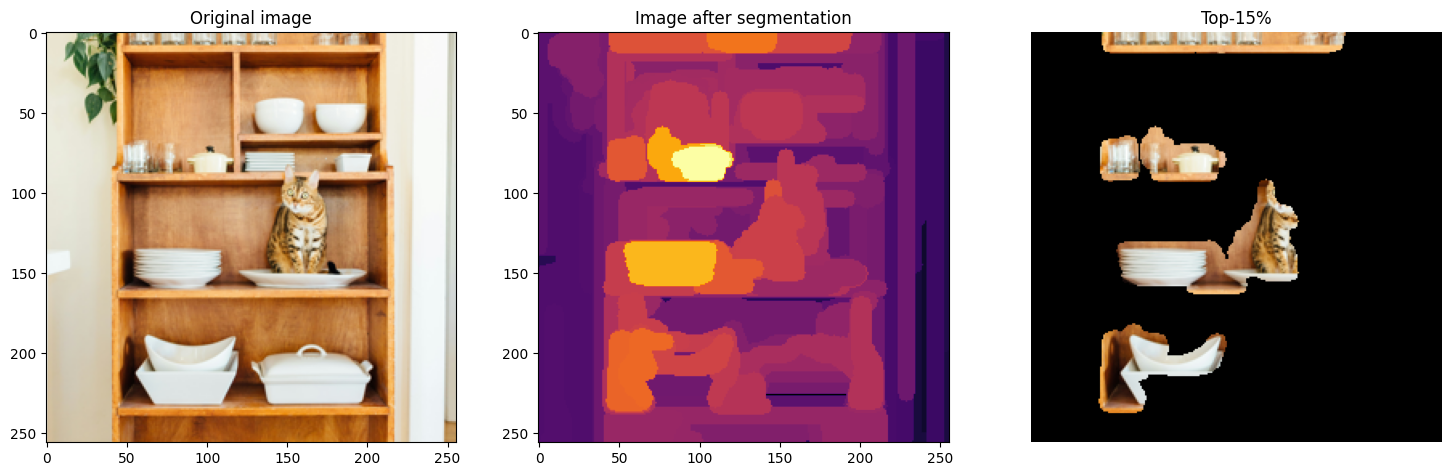

In [25]:
# Выделим топ15 важных пикселей
mask = xrai_attributions >= np.percentile(xrai_attributions, 85)
im_mask = np.array(original_image)
im_mask[~mask] = 0

fig, ax = plt.subplots(1, 3, figsize=(18, 8))

ax[0].imshow(original_image)
ax[0].set_title('Original image')

ax[1].imshow(xrai_attributions, cmap='inferno')
ax[1].set_title('Image after segmentation')

ax[2].imshow(im_mask)
ax[2].set_title('Top-15%')
plt.axis('off');

**Спасибо за работу! С нетерпением ждем ваших эссе! :)**